In [27]:
import pandas as pd
import numpy as np
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

In [4]:
df = pd.read_csv("churn_modelling.csv")

In [5]:
df.shape

(10000, 14)

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
X = df.iloc[:,3:]

In [8]:
id = df.iloc[:,1]

In [9]:
scaler = MinMaxScaler()

In [10]:
X = pd.get_dummies(X,dtype=float)

In [11]:
X.shape

(10000, 14)

In [12]:
X = scaler.fit_transform(X)

In [13]:
som = MiniSom(10,10,X.shape[1],sigma=1,learning_rate=0.5)

In [14]:
som.random_weights_init(X)

In [15]:
som.train_random(X,num_iteration=100)

In [25]:
def visualize_distance_map(som):
    """
    Visualize the distance map (U-Matrix) of a trained MiniSom SOM.

    Parameters:
    som (MiniSom): A trained MiniSom instance.
    """
    # Get the weights from the SOM
    weights = som.get_weights()

    # Calculate the U-Matrix (distance map)
    umatrix = np.zeros((som._weights.shape[0], som._weights.shape[1]))

    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            neighbors = []
            if i > 0:
                neighbors.append(weights[i-1, j])  # Top neighbor
            if i < weights.shape[0] - 1:
                neighbors.append(weights[i+1, j])  # Bottom neighbor
            if j > 0:
                neighbors.append(weights[i, j-1])  # Left neighbor
            if j < weights.shape[1] - 1:
                neighbors.append(weights[i, j+1])  # Right neighbor

            # Calculate the average distance to neighbors
            if neighbors:
                umatrix[i, j] = np.linalg.norm(weights[i, j] - np.mean(neighbors, axis=0))

    # Plot the U-Matrix
    plt.figure(figsize=(8, 8))
    plt.pcolor(umatrix.T, cmap='bone_r')  # Transpose for correct orientation
    plt.colorbar()
    plt.title('Distance Map (U-Matrix)')
    plt.show()

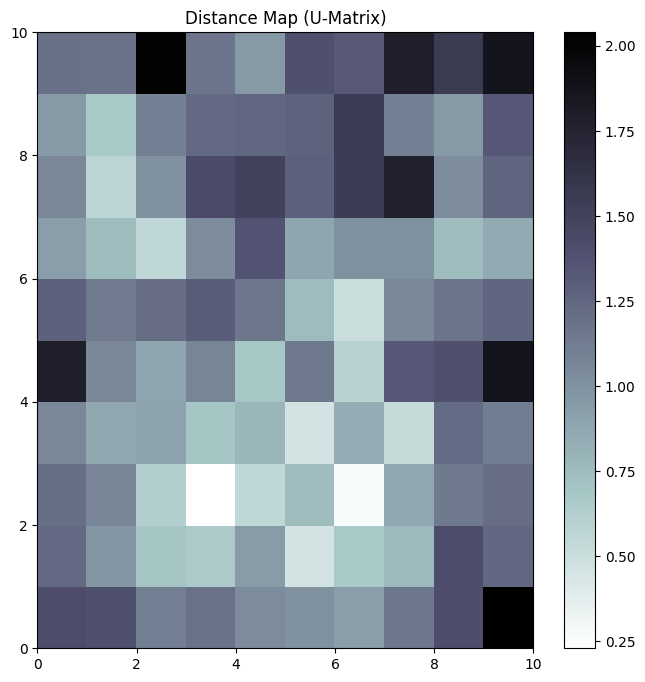

In [26]:
visualize_distance_map(som)

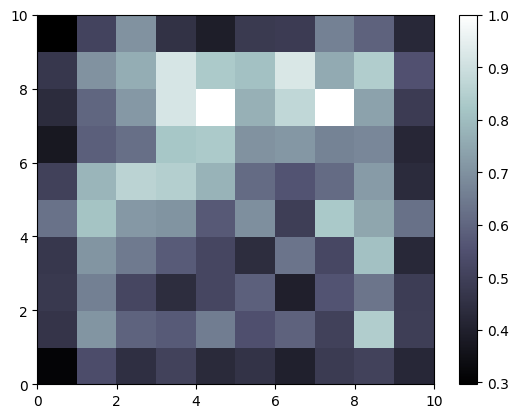

In [28]:
plb.bone()
plb.pcolor(som.distance_map().T)
plb.colorbar()

In [33]:
plb.savefig("churn modeling som distance map.png",bbox_inches='tight', pad_inches=0.0)
# Close the plot
plb.close()

In [34]:
def get_outliers(som, data, threshold=2.0):
    """
    Identify outliers in the data based on their distance from the BMU in the trained SOM.

    Parameters:
    som (MiniSom): A trained MiniSom instance.
    data (np.ndarray): The input data (n_samples, n_features).
    threshold (float): The threshold for identifying outliers. Data points with a quantization error
                       greater than this threshold are considered outliers. Default is 2.0.

    Returns:
    outliers (np.ndarray): The indices of the outlier data points.
    quantization_errors (np.ndarray): The quantization error for each data point.
    """
    quantization_errors = []
    outliers = []

    for i, x in enumerate(data):
        # Find the BMU for the data point
        bmu = som.winner(x)
        bmu_weights = som.get_weights()[bmu]

        # Calculate the quantization error (distance between the data point and its BMU)
        error = np.linalg.norm(x - bmu_weights)
        quantization_errors.append(error)

        # Check if the error exceeds the threshold
        if error > threshold:
            outliers.append(i)

    return np.array(outliers), np.array(quantization_errors)

In [50]:
outliers, quantization_errors = get_outliers(som, X, threshold=1.4)
print("Outlier indices:", outliers)

Outlier indices: [2462 7698]


In [52]:
outliers

array([2462, 7698])

In [46]:
def get_outlier_list(som, data):
    """
    Identify outliers in the data based on their distance from the BMU in the trained SOM.

    Parameters:
    som (MiniSom): A trained MiniSom instance.
    data (np.ndarray): The input data (n_samples, n_features).
    threshold (float): The threshold for identifying outliers. Data points with a quantization error
                       greater than this threshold are considered outliers. Default is 2.0.

    Returns:
    outliers (np.ndarray): The indices of the outlier data points.
    quantization_errors (np.ndarray): The quantization error for each data point.
    """
    quantization_errors = []
    outliers = []

    for i, x in enumerate(data):
        # Find the BMU for the data point
        bmu = som.winner(x)
        bmu_weights = som.get_weights()[bmu]
        # Calculate the quantization error (distance between the data point and its BMU)
        error = np.linalg.norm(x - bmu_weights)
        quantization_errors.append(error)

    mean_error = np.mean(quantization_errors)
    std_error = np.std(quantization_errors)
    for i, error in enumerate(quantization_errors):
        if error > mean_error + 3 * std_error:
            outliers.append(error)        

    return np.array(outliers), np.array(quantization_errors)

In [47]:
outliers,_ = get_outlier_list(som,X)

In [48]:
len(outliers)

45

In [49]:
outliers

array([1.39138383, 1.30699075, 1.35361081, 1.3285779 , 1.29265364,
       1.39075782, 1.34260155, 1.31745855, 1.32977354, 1.38771351,
       1.40256312, 1.34656768, 1.38331451, 1.31969128, 1.29434662,
       1.3123419 , 1.31129534, 1.37412508, 1.33088173, 1.29126011,
       1.31854663, 1.3064269 , 1.28567623, 1.35561861, 1.33609759,
       1.33084522, 1.29679618, 1.36092306, 1.33874453, 1.29830969,
       1.34687774, 1.30633884, 1.3352838 , 1.33030768, 1.34257341,
       1.38446413, 1.40318195, 1.3411772 , 1.39248983, 1.3699478 ,
       1.30855586, 1.35321092, 1.29742041, 1.29501601, 1.3475712 ])